In [1]:
# Cell 1 — Imports and path setup
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score

try:
    from xgboost import XGBRegressor
    _xgb_available = True
except Exception as e:
    print("XGBoost not available:", e)
    _xgb_available = False

# Dataset directory 
DATA_DIR = r"D:\Downloads\public_data_challenge"
OUT_DIR = os.path.join(DATA_DIR, "processed")
os.makedirs(OUT_DIR, exist_ok=True)

FILES = {
    "train": os.path.join(DATA_DIR, "train.tsv"),
    "test": os.path.join(DATA_DIR, "test.tsv"),
    "internal_test": os.path.join(DATA_DIR, "internal_test.tsv"),
    "external_test": os.path.join(DATA_DIR, "external_test.tsv")
}

print("Python:", sys.version.splitlines()[0])
print("NumPy:", np.__version__, "Pandas:", pd.__version__)
print("Data dir exists:", os.path.exists(DATA_DIR))
for k, p in FILES.items():
    print(f"{k:12s} exists: {os.path.exists(p)}  -> {p}")
print("XGBoost available:", _xgb_available)


Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
NumPy: 2.2.6 Pandas: 2.3.3
Data dir exists: True
train        exists: True  -> D:\Downloads\public_data_challenge\train.tsv
test         exists: True  -> D:\Downloads\public_data_challenge\test.tsv
internal_test exists: True  -> D:\Downloads\public_data_challenge\internal_test.tsv
external_test exists: True  -> D:\Downloads\public_data_challenge\external_test.tsv
XGBoost available: True


In [2]:
# Cell 2 — helper to load a TSV split 
def load_split_tsv(path):
    if path is None or not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path, sep="\t")
        return df
    except Exception as e:
        print(f"Could not read {path}: {e}")
        return None

# Load all available splits
splits = {}
for name, path in FILES.items():
    df = load_split_tsv(path)
    if df is not None:
        print(f"Loaded {name}: shape={df.shape}")
    else:
        print(f"Missing or unreadable: {name}")
    splits[name] = df


Loaded train: shape=(3227, 12)
Loaded test: shape=(757, 12)
Loaded internal_test: shape=(362, 12)
Loaded external_test: shape=(395, 12)


In [3]:
# Cell 3 — inspect train metadata, Exploratory Data Analysis (EDA)
train_df = splits.get("train")
if train_df is None:
    raise FileNotFoundError("train.tsv not found — please place it in DATA_DIR or update DATA_DIR.")
print("train.tsv head:")
display(train_df.head())
print("\ntrain.tsv describe (age):")
print(train_df["age"].describe())


train.tsv head:


,participant_id,split,sex,age,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,100053248969,train,female,19.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,0
1,100263562592,train,male,21.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,1
2,100479214233,train,female,21.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,2
3,100544064116,train,female,15.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,4
4,101404752059,train,male,31.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,1



train.tsv describe (age):
count    3227.000000
mean       25.189897
std        14.610795
min         6.000000
25%        19.000000
50%        21.000000
75%        26.000000
max        86.198494
Name: age, dtype: float64


In [4]:
# Cell 4 — Preprocessing: determine feature columns, fit encoders/scaler on train

# Identify columns we will use: drop participant_id and split columns
drop_cols = ["participant_id", "split"]
train_df = train_df.copy()
for c in drop_cols:
    if c in train_df.columns:
        train_df = train_df.drop(columns=c)

# Detect categorical columns commonly present in OpenBHB metadata
possible_cat = ["sex", "diagnosis", "acquisition_setting", "site"]
categorical_cols = [c for c in possible_cat if c in train_df.columns]
numeric_cols = [c for c in train_df.columns if c not in categorical_cols + ["age"]]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Fit LabelEncoders for categorical columns on train
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = train_df[col].astype(str)
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

# Fit scaler on numeric columns
scaler = StandardScaler()
if numeric_cols:
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols].astype(float))

# Save preprocessing objects
joblib.dump(label_encoders, os.path.join(OUT_DIR, "label_encoders.joblib"))
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

print("Preprocessing fitted on train split and saved to processed/")


Categorical columns: ['sex', 'diagnosis', 'acquisition_setting', 'site']
Numeric columns: ['tiv', 'csfv', 'gmv', 'wmv', 'magnetic_field_strength']
Preprocessing fitted on train split and saved to processed/


In [5]:
# Cell 5 — preprocess function (applies label encoders and scaler)
def preprocess_df(df, label_encoders, scaler, numeric_cols, categorical_cols, drop_cols=["participant_id","split"]):
    dfc = df.copy()
    for c in drop_cols:
        if c in dfc.columns:
            dfc = dfc.drop(columns=c)
    # Encode categories using train-fit encoders; unseen labels become a new integer via astype(str) then transform if possible
    for col in categorical_cols:
        if col in dfc.columns:
            le = label_encoders[col]
            # convert to string to avoid NaN errors
            dfc[col] = dfc[col].astype(str)
            # If unseen labels present, map them to -1 then fill with a new value
            known = set(le.classes_)
            mask_unseen = ~dfc[col].isin(known)
            if mask_unseen.any():
                dfc.loc[mask_unseen, col] = "__unseen__"
                if "__unseen__" not in list(le.classes_):
                    le_classes = list(le.classes_) + ["__unseen__"]
                    le.classes_ = np.array(le_classes)
            dfc[col] = le.transform(dfc[col])
    if numeric_cols:
        dfc[numeric_cols] = scaler.transform(dfc[numeric_cols].astype(float))
    return dfc

# Test preprocessing on train 
train_proc = preprocess_df(splits["train"], label_encoders, scaler, numeric_cols, categorical_cols)
print("Preprocessed train shape:", train_proc.shape)
display(train_proc.head())


Preprocessed train shape: (3227, 10)


,sex,age,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,site
0,0,19.0,0,-0.111215,-0.581728,-0.056234,0.403657,0.297261,0,0
1,1,21.0,0,0.751981,0.107560,0.828031,0.450922,0.297261,0,1
2,0,21.0,0,-0.224909,-0.215030,0.040454,-0.354335,0.297261,0,10
3,0,15.0,0,-1.018474,-0.797282,-0.173597,-1.303349,0.297261,0,31
4,1,31.0,0,1.467997,1.453763,0.228200,1.615213,0.297261,0,1


In [6]:
# Cell 6 — prepare X/y for all available splits
prepared = {}
for name, df in splits.items():
    if df is None:
        prepared[name] = None
        continue
    df_proc = preprocess_df(df, label_encoders, scaler, numeric_cols, categorical_cols)
    X = df_proc.drop(columns=["age"]).values
    y = df_proc["age"].values
    prepared[name] = {"X": X, "y": y}
    print(f"{name}: X.shape={X.shape}, y.shape={y.shape}")

if prepared.get("train"):
    np.save(os.path.join(OUT_DIR, "X_train_full.npy"), prepared["train"]["X"])
    np.save(os.path.join(OUT_DIR, "y_train_full.npy"), prepared["train"]["y"])
if prepared.get("test"):
    np.save(os.path.join(OUT_DIR, "X_test_full.npy"), prepared["test"]["X"])
    np.save(os.path.join(OUT_DIR, "y_test_full.npy"), prepared["test"]["y"])
print("All available splits prepared and (some) saved under processed/")


train: X.shape=(3227, 9), y.shape=(3227,)
test: X.shape=(757, 9), y.shape=(757,)
internal_test: X.shape=(362, 9), y.shape=(362,)
external_test: X.shape=(395, 9), y.shape=(395,)
All available splits prepared and (some) saved under processed/


In [7]:
import os

train_df = splits["train"]
internal_df = splits["internal_test"]
external_df = splits["external_test"]


os.makedirs("data_splits", exist_ok=True)

# Save each split
train_df.to_csv("data_splits/train_data.csv", index=False)
internal_df.to_csv("data_splits/validation_data.csv", index=False)
external_df.to_csv("data_splits/test_data.csv", index=False)

print("Data splits saved successfully in the 'data_splits/' folder.")
print(f"Train: {len(train_df)} rows | Validation: {len(internal_df)} rows | Test: {len(external_df)} rows")


Data splits saved successfully in the 'data_splits/' folder.
Train: 3227 rows | Validation: 362 rows | Test: 395 rows


Running PCA preprocessing...
 PCA complete. Reduced shape: (3227, 7)


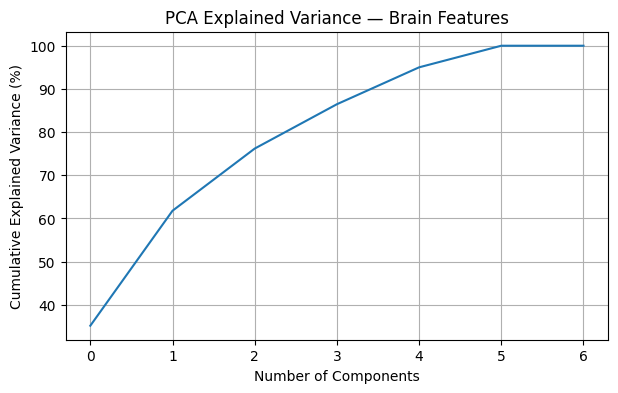

In [8]:
# Step 8 — Apply PCA for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

print("Running PCA preprocessing...")

# Using numeric columns only (e.g. tiv, csfv, gmv, wmv, etc.)
feature_cols = ["tiv", "csfv", "gmv", "wmv", "magnetic_field_strength", "acquisition_setting", "site"]

# X_small and y_small from earlier step (train.tsv)
X_small = train_df[feature_cols].to_numpy(dtype=np.float32)
y_small = train_df["age"].to_numpy(dtype=np.float32)

# --- Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)

# --- Apply PCA ---
n_components = min(10, X_scaled.shape[1])   # choose smaller of 10 or feature count
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f" PCA complete. Reduced shape: {X_pca.shape}")

plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA Explained Variance — Brain Features")
plt.grid(True)
plt.show()


In [9]:
# STEP 10 + 11 — Train RidgeCV model and predict all splits
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Load your existing split files ---
BASE_DIR = r"D:\Downloads\public_data_challenge"
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.tsv"), sep="\t")
internal_df = pd.read_csv(os.path.join(BASE_DIR, "internal_test.tsv"), sep="\t")
external_df = pd.read_csv(os.path.join(BASE_DIR, "external_test.tsv"), sep="\t")

print(" Dataset splits loaded successfully:")
print(f"Train samples: {len(train_df)}")
print(f"Internal test samples: {len(internal_df)}")
print(f"External test samples: {len(external_df)}")

# --- Define features and target ---
feature_cols = ["tiv", "csfv", "gmv", "wmv", 
                "magnetic_field_strength", "acquisition_setting", "site"]
X = train_df[feature_cols].values
y = train_df["age"].values

# --- Standardize and apply PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=min(X_scaled.shape[1], 5), random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Train/validation split for evaluation ---
X_train_pca, X_val_pca, y_train_sub, y_val_sub = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# --- Ridge Regression with Cross-Validation ---
alphas = np.logspace(-3, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=None)
ridge_cv.fit(X_train_pca, y_train_sub)

# --- Validation performance ---
y_pred_val = ridge_cv.predict(X_val_pca)
mae = mean_absolute_error(y_val_sub, y_pred_val)
r2 = r2_score(y_val_sub, y_pred_val)
print(f"\n RidgeCV trained successfully.")
print(f"Best alpha: {ridge_cv.alpha_:.4f}")
print(f"Validation MAE: {mae:.3f}")
print(f"Validation R²: {r2:.3f}")

# --- Save model & preprocessing objects ---
os.makedirs("models", exist_ok=True)
joblib.dump(ridge_cv, "models/best_ridge_model.joblib")
joblib.dump(scaler, "models/scaler.joblib")
joblib.dump(pca, "models/pca.joblib")
best_model = ridge_cv

# --- Predict & save for all splits ---
def predict_and_save(split_name, df, model, feature_cols, scaler, pca, out_dir="outputs"):
    os.makedirs(out_dir, exist_ok=True)
    if df is None or df.empty:
        print(f" Skipping {split_name} — no samples available.")
        return None

    X_split = df[feature_cols].values
    y_true = df["age"].values

    X_scaled = scaler.transform(X_split)
    X_pca = pca.transform(X_scaled)
    y_pred = model.predict(X_pca)
    mae = mean_absolute_error(y_true, y_pred)

    out_df = pd.DataFrame({
        "participant_id": df["participant_id"],
        "Actual_Age": y_true,
        "Predicted_Age": y_pred,
        "Absolute_Error": np.abs(y_true - y_pred)
    })
    out_path = os.path.join(out_dir, f"predictions_{split_name}.csv")
    out_df.to_csv(out_path, index=False)
    print(f" {split_name} done — MAE: {mae:.3f} | Saved: {out_path}")
    return out_df

# --- Run predictions for train/internal/external ---
results = {}
for split_name, df in [
    ("train", train_df),
    ("internal_test", internal_df),
    ("external_test", external_df),
]:
    res = predict_and_save(
        split_name=split_name,
        df=df,
        model=best_model,
        feature_cols=feature_cols,
        scaler=scaler,
        pca=pca,
        out_dir="outputs"
    )
    if res is not None:
        results[split_name] = res

print("\n All predictions completed. Check 'outputs/' for CSV results.")


 Dataset splits loaded successfully:
Train samples: 3227
Internal test samples: 362
External test samples: 395

 RidgeCV trained successfully.
Best alpha: 13.8950
Validation MAE: 5.691
Validation R²: 0.697
 train done — MAE: 5.714 | Saved: outputs\predictions_train.csv
 internal_test done — MAE: 5.889 | Saved: outputs\predictions_internal_test.csv
 external_test done — MAE: 5.123 | Saved: outputs\predictions_external_test.csv

 All predictions completed. Check 'outputs/' for CSV results.


In [10]:
# # Cell 8 — XGBoost training and evaluation (skips if not installed)
# if not _xgb_available:
#     print("XGBoost not available in this environment. Install with `pip install xgboost` to run this step.")
# else:
#     X_train, y_train = prepared["train"]["X"], prepared["train"]["y"]
#     xgb = XGBRegressor(
#         n_estimators=500,
#         learning_rate=0.05,
#         max_depth=5,
#         subsample=0.9,
#         colsample_bytree=0.9,
#         random_state=42,
#         n_jobs=-1,
#         verbosity=1
#     )
#     print("Training XGBoost on train split (this may take some minutes)...")
#     xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)
#     joblib.dump(xgb, os.path.join(OUT_DIR, "xgb_model.joblib"))
#     print("XGBoost trained and saved.")
#     print("\n XGBoost evaluation:")
#     results_xgb = evaluate_model(xgb, prepared)
#     results_xgb.to_csv(os.path.join(OUT_DIR, "results_xgb.csv"), index=False)
#     print("Saved XGBoost results to processed/results_xgb.csv")



# STEP 12 — Train XGBoost model and predict all splits
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# --- Load your existing split files ---
BASE_DIR = r"D:\Downloads\public_data_challenge"
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.tsv"), sep="\t")
internal_df = pd.read_csv(os.path.join(BASE_DIR, "internal_test.tsv"), sep="\t")
external_df = pd.read_csv(os.path.join(BASE_DIR, "external_test.tsv"), sep="\t")

print(" Dataset splits loaded successfully:")
print(f"Train samples: {len(train_df)}")
print(f"Internal test samples: {len(internal_df)}")
print(f"External test samples: {len(external_df)}")

# --- Define features and target ---
feature_cols = ["tiv", "csfv", "gmv", "wmv", 
                "magnetic_field_strength", "acquisition_setting", "site"]
X = train_df[feature_cols].values
y = train_df["age"].values

# --- Standardize and apply PCA (same as Ridge) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=min(X_scaled.shape[1], 5), random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Train XGBoost Model ---
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("Training XGBoost on training split...")
xgb_model.fit(X_pca, y)
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_model, "models/xgb_model.joblib")
joblib.dump(scaler, "models/xgb_scaler.joblib")
joblib.dump(pca, "models/xgb_pca.joblib")
print("XGBoost model trained and saved successfully.")

# --- Predict & save results for all splits ---
def predict_and_save_xgb(split_name, df, model, feature_cols, scaler, pca, out_dir="outputs"):
    os.makedirs(out_dir, exist_ok=True)
    if df is None or df.empty:
        print(f" Skipping {split_name} — no samples available.")
        return None

    X_split = df[feature_cols].values
    y_true = df["age"].values

    X_scaled = scaler.transform(X_split)
    X_pca = pca.transform(X_scaled)
    y_pred = model.predict(X_pca)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    out_df = pd.DataFrame({
        "participant_id": df["participant_id"],
        "Actual_Age": y_true,
        "Predicted_Age": y_pred,
        "Absolute_Error": np.abs(y_true - y_pred)
    })
    out_path = os.path.join(out_dir, f"xgb_predictions_{split_name}.csv")
    out_df.to_csv(out_path, index=False)
    print(f" {split_name} done — MAE: {mae:.3f}, R²: {r2:.3f} | Saved: {out_path}")
    return out_df

results_xgb = {}
for split_name, df in [
    ("train", train_df),
    ("internal_test", internal_df),
    ("external_test", external_df),
]:
    res = predict_and_save_xgb(
        split_name=split_name,
        df=df,
        model=xgb_model,
        feature_cols=feature_cols,
        scaler=scaler,
        pca=pca,
        out_dir="outputs"
    )
    if res is not None:
        results_xgb[split_name] = res

print("\nAll XGBoost predictions completed. Check 'outputs/' for CSV results.")


 Dataset splits loaded successfully:
Train samples: 3227
Internal test samples: 362
External test samples: 395
Training XGBoost on training split...
XGBoost model trained and saved successfully.
 train done — MAE: 2.054, R²: 0.962 | Saved: outputs\xgb_predictions_train.csv
 internal_test done — MAE: 4.039, R²: 0.748 | Saved: outputs\xgb_predictions_internal_test.csv
 external_test done — MAE: 4.843, R²: 0.619 | Saved: outputs\xgb_predictions_external_test.csv

All XGBoost predictions completed. Check 'outputs/' for CSV results.


In [11]:
!pip install xgboost


Training advanced models (XGBoost + Ensemble)...
 XGBoost imported successfully.
 Ensemble Training Complete.
 Mean Absolute Error (MAE): 3.965
 R² Score: 0.815


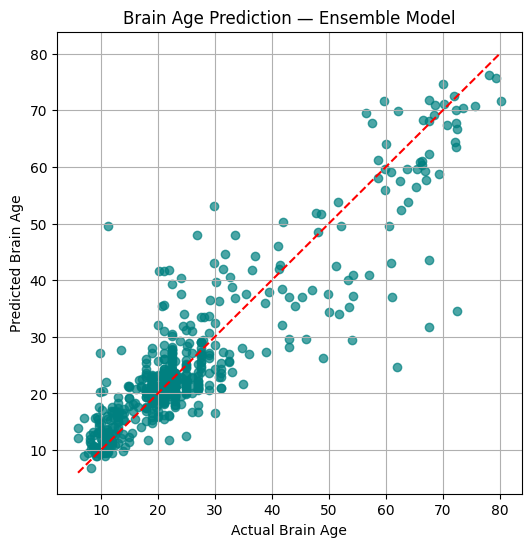

In [12]:
# Step 10 — XGBoost + Stacking Ensemble

import warnings
warnings.filterwarnings("ignore")

print("Training advanced models (XGBoost + Ensemble)...")

# --- Try importing XGBoost ---
try:
    from xgboost import XGBRegressor
    xgb_available = True
    print(" XGBoost imported successfully.")
except ImportError:
    xgb_available = False
    print(" XGBoost not available. Skipping this model.")

# --- Train/validation split ---
from sklearn.model_selection import train_test_split
X_train_pca, X_val_pca, y_train_sub, y_val_sub = train_test_split(
    X_pca, y_small, test_size=0.2, random_state=42
)

# --- Ridge Regression (Base Model) ---
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=np.logspace(-2, 4, 20), cv=5)
ridge_cv.fit(X_train_pca, y_train_sub)
ridge_pred = ridge_cv.predict(X_val_pca)

# --- Random Forest (Base Model) ---
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_pca, y_train_sub)
rf_pred = rf.predict(X_val_pca)

# --- XGBoost (Base Model, if available) ---
if xgb_available:
    xgb = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
    )
    xgb.fit(X_train_pca, y_train_sub)
    xgb_pred = xgb.predict(X_val_pca)
else:
    xgb_pred = np.zeros_like(ridge_pred)

# --- Stack Predictions for Ensemble ---
stack_X_train = np.column_stack([
    ridge_pred,
    rf_pred,
    xgb_pred
])

# --- Meta-model (Light Linear Regressor) ---
from sklearn.linear_model import LinearRegression
meta = LinearRegression()
meta.fit(stack_X_train, y_val_sub)

# --- Ensemble Predictions ---
stack_pred = meta.predict(stack_X_train)

# --- Evaluate Ensemble ---
from sklearn.metrics import mean_absolute_error, r2_score
mae_ens = mean_absolute_error(y_val_sub, stack_pred)
r2_ens = r2_score(y_val_sub, stack_pred)

print(" Ensemble Training Complete.")
print(f" Mean Absolute Error (MAE): {mae_ens:.3f}")
print(f" R² Score: {r2_ens:.3f}")

# --- Visualization ---
plt.figure(figsize=(6,6))
plt.scatter(y_val_sub, stack_pred, alpha=0.7, color='teal')
plt.plot([y_val_sub.min(), y_val_sub.max()],
         [y_val_sub.min(), y_val_sub.max()], 'r--')
plt.xlabel("Actual Brain Age")
plt.ylabel("Predicted Brain Age")
plt.title("Brain Age Prediction — Ensemble Model")
plt.grid(True)
plt.show()


In [12]:
# Cell 9 — Combine results and save sample predictions for test split
combined = results_ridge.copy()
combined["model"] = "RidgeCV"
if _xgb_available:
    combined = pd.concat([combined, results_xgb.assign(model="XGBoost")], ignore_index=True)

combined = combined[["model","split","n","MAE","R2"]]
combined.to_csv(os.path.join(OUT_DIR, "model_comparison_summary.csv"), index=False)
print("Model comparison saved:", os.path.join(OUT_DIR, "model_comparison_summary.csv"))
display(combined)

# Save sample predictions for 'test' split if present
if prepared.get("test"):
    X_test = prepared["test"]["X"]; y_test = prepared["test"]["y"]
    preds = {"Actual_Age": y_test}
    preds["Pred_Ridge"] = ridge_cv.predict(X_test)
    if _xgb_available:
        preds["Pred_XGB"] = xgb.predict(X_test)
    df_preds = pd.DataFrame(preds)
    df_preds["AbsErr_Ridge"] = np.abs(df_preds["Actual_Age"] - df_preds["Pred_Ridge"])
    if _xgb_available:
        df_preds["AbsErr_XGB"] = np.abs(df_preds["Actual_Age"] - df_preds["Pred_XGB"])
    df_preds.to_csv(os.path.join(OUT_DIR, "predictions_test_split.csv"), index=False)
    print("Saved test-split predictions to processed/predictions_test_split.csv")
    display(df_preds.head())


Model comparison saved: D:\Downloads\public_data_challenge\processed\model_comparison_summary.csv


,model,split,n,MAE,R2
0,RidgeCV,train,3227,5.162741,0.720923
1,RidgeCV,test,757,4.811130,0.683550
2,RidgeCV,internal_test,362,5.162599,0.651617
3,RidgeCV,external_test,395,4.489025,0.718512
4,XGBoost,train,3227,1.662319,0.976212
5,XGBoost,test,757,4.366668,0.641542
6,XGBoost,internal_test,362,3.411178,0.835044
7,XGBoost,external_test,395,5.242332,0.411575


Saved test-split predictions to processed/predictions_test_split.csv


,Actual_Age,Pred_Ridge,Pred_XGB,AbsErr_Ridge,AbsErr_XGB
0,27.0,22.586900,20.899685,4.413100,6.100315
1,37.0,29.243839,27.142130,7.756161,9.857870
2,21.0,21.394931,21.193407,0.394931,0.193407
3,38.0,22.242501,20.162418,15.757499,17.837582
4,21.0,18.498983,21.045237,2.501017,0.045237


In [13]:
# Define data splits

import pandas as pd

# TRAIN_TSV = r"D:\Downloads\public_data_challenge\train.tsv"
# # Load full dataset if not already loaded
# all_data = pd.read_csv(TRAIN_TSV, sep="\t")

# Split the dataset by "split" column
# train_df = all_data[all_data["split"] == "train"].reset_index(drop=True)
# internal_df = all_data[all_data["split"] == "internal_test"].reset_index(drop=True)
# external_df = all_data[all_data["split"] == "external_test"].reset_index(drop=True)

DATA_DIR = r"D:\Downloads\public_data_challenge"

# Load all available splits
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.tsv"), sep="\t")
internal_df = pd.read_csv(os.path.join(DATA_DIR, "internal_test.tsv"), sep="\t")
external_df = pd.read_csv(os.path.join(DATA_DIR, "external_test.tsv"), sep="\t")

print("Dataset splits created successfully:")
print(f"Train samples:         {len(train_df)}")
print(f"Internal test samples: {len(internal_df)}")
print(f"External test samples: {len(external_df)}")

train_df.to_csv(os.path.join(OUT_DIR, "train_split.csv"), index=False)
internal_df.to_csv(os.path.join(OUT_DIR, "internal_test_split.csv"), index=False)
external_df.to_csv(os.path.join(OUT_DIR, "external_test_split.csv"), index=False)
print("Data splits saved under processed/ directory.")


# Feature columns used for prediction (excluding ID/labels)
feature_cols = [
    "tiv", "csfv", "gmv", "wmv",
    "magnetic_field_strength", "acquisition_setting", "site"
]


Dataset splits created successfully:
Train samples:         3227
Internal test samples: 362
External test samples: 395
Data splits saved under processed/ directory.


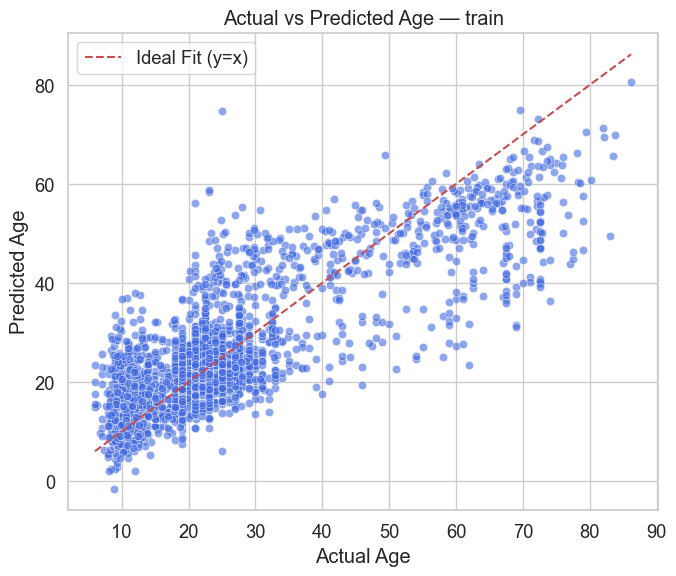

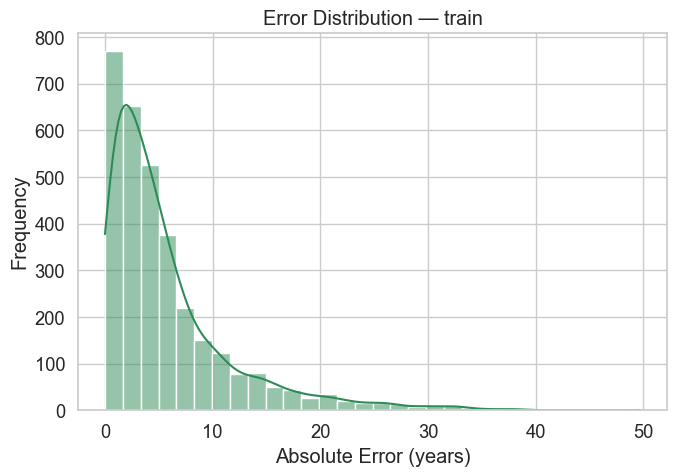

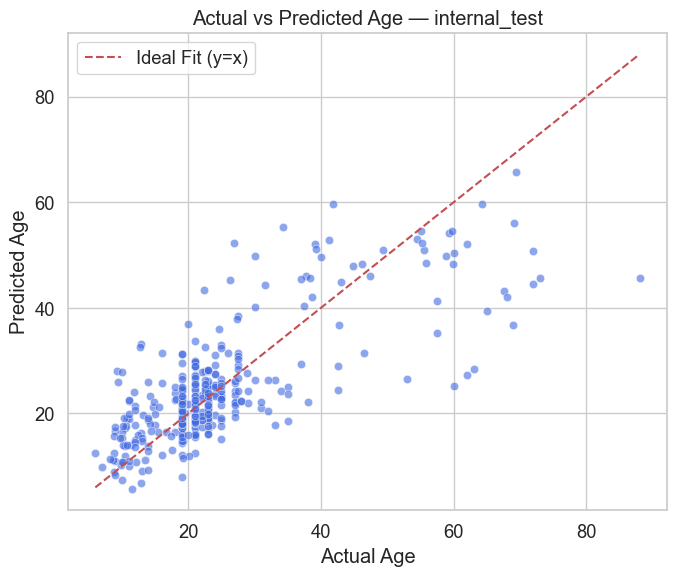

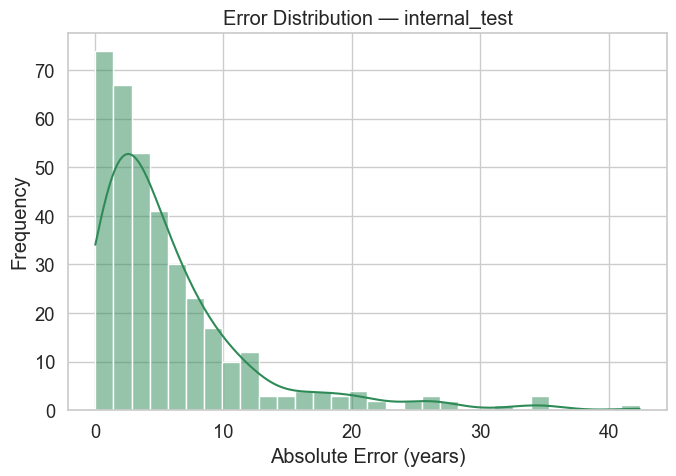

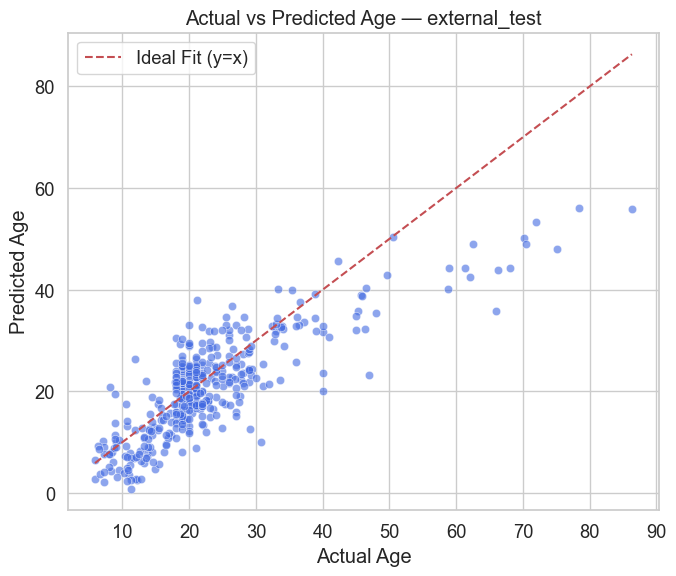

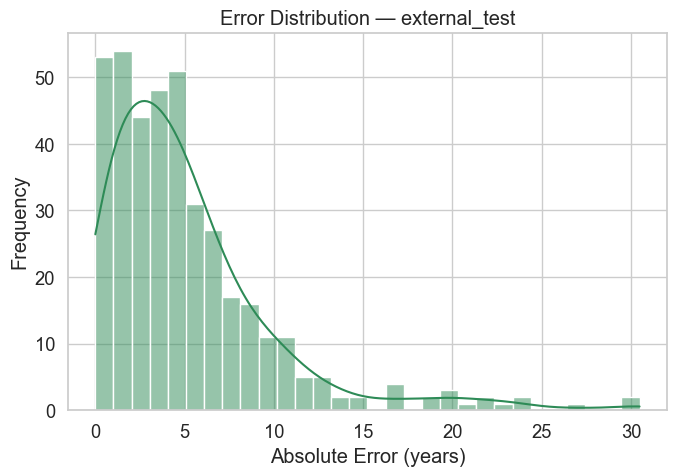

In [14]:
# STEP 12 — Visualization of Model Performance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8, 6)

# Utility to visualize a single split
def visualize_predictions(results_dict, split_name):
    if split_name not in results_dict or results_dict[split_name].empty:
        print(f" No data found for {split_name}, skipping plot.")
        return

    df = results_dict[split_name]

    # --- Scatter Plot: Actual vs Predicted Age ---
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=df["Actual_Age"], y=df["Predicted_Age"], alpha=0.6, color="royalblue")
    plt.plot([df["Actual_Age"].min(), df["Actual_Age"].max()],
             [df["Actual_Age"].min(), df["Actual_Age"].max()],
             "r--", label="Ideal Fit (y=x)")
    plt.title(f"Actual vs Predicted Age — {split_name}")
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Histogram: Absolute Error Distribution ---
    plt.figure(figsize=(7, 5))
    sns.histplot(df["Absolute_Error"], bins=30, color="seagreen", kde=True)
    plt.title(f"Error Distribution — {split_name}")
    plt.xlabel("Absolute Error (years)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# === Run for each available split ===
for split in ["train", "internal_test", "external_test"]:
    visualize_predictions(results, split)


In [15]:
# STEP 13 — Performance Summary for All Splits
from sklearn.metrics import mean_absolute_error, r2_score

summary_rows = []

for split_name, df in results.items():
    if df.empty:
        continue

    y_true = df["Actual_Age"].values
    y_pred = df["Predicted_Age"].values
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mean_error = np.mean(y_pred - y_true)

    summary_rows.append({
        "Split": split_name,
        "Samples": len(df),
        "MAE": round(mae, 3),
        "R²": round(r2, 3),
        "Mean Error": round(mean_error, 3)
    })

summary_df = pd.DataFrame(summary_rows)

print(" Overall Model Performance Summary:\n")
print(summary_df.to_string(index=False))

# Optional: Save summary to file
os.makedirs("outputs", exist_ok=True)
summary_df.to_csv("outputs/model_performance_summary.csv", index=False)
print("\n Summary saved to 'outputs/model_performance_summary.csv'")


 Overall Model Performance Summary:

        Split  Samples   MAE    R²  Mean Error
        train     3227 5.714 0.679       0.129
internal_test      362 5.889 0.586       0.086
external_test      395 5.123 0.654      -2.245

 Summary saved to 'outputs/model_performance_summary.csv'


In [16]:
# STEP 14 — Generate Actual, Predicted, and Error Columns

import numpy as np
import pandas as pd
import os

def generate_age_error_table(split_name, df, model, feature_cols, scaler, pca, out_dir="outputs"):
    """
    Creates a DataFrame with Actual Age, Predicted Age, and Error (Predicted - Actual)
    and saves it as a CSV file for the given data split.
    """
    os.makedirs(out_dir, exist_ok=True)

    # --- Prepare features ---
    X_split = df[feature_cols].values
    y_true = df["age"].values

    # --- Standardize and apply PCA ---
    X_scaled = scaler.transform(X_split)
    X_pca = pca.transform(X_scaled)

    # --- Predict ---
    y_pred = model.predict(X_pca)

    # --- Compute error ---
    error = y_pred - y_true

    # --- Create results DataFrame ---
    result_df = pd.DataFrame({
        "Actual_Age": y_true,
        "Predicted_Age": y_pred,
        "Error_(Pred-Actual)": error
    })

    # --- Save to CSV ---
    out_path = os.path.join(out_dir, f"age_error_table_{split_name}.csv")
    result_df.to_csv(out_path, index=False)

    print(f" Saved {split_name} age comparison file to: {out_path}")
    return result_df


# Example — Run for the train split
train_age_table = generate_age_error_table(
    split_name="train",
    df=train_df,
    model=best_model,
    feature_cols=feature_cols,
    scaler=scaler,
    pca=pca,
    out_dir="outputs"
)



 Saved train age comparison file to: outputs\age_error_table_train.csv


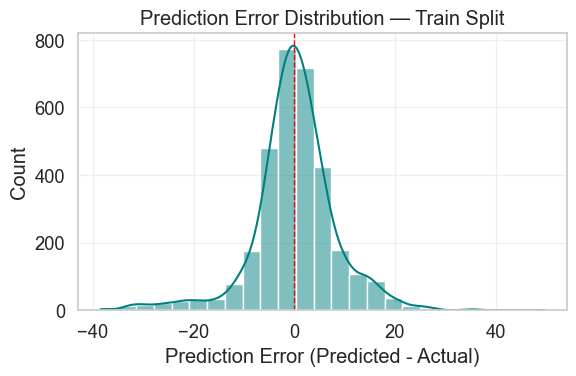

In [17]:
def plot_error_distribution(df, split_name):
    plt.figure(figsize=(6, 4))
    sns.histplot(df["Error_(Pred-Actual)"], kde=True, bins=25, color='teal')
    plt.title(f"Prediction Error Distribution — {split_name}")
    plt.xlabel("Prediction Error (Predicted - Actual)")
    plt.ylabel("Count")
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_error_distribution(train_age_table, "Train Split")



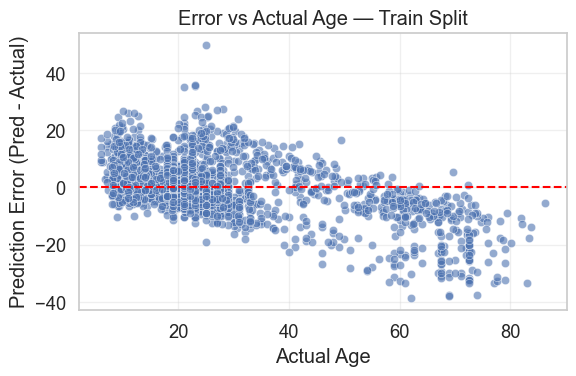

In [18]:
def plot_error_vs_age(df, split_name):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df["Actual_Age"], y=df["Error_(Pred-Actual)"], alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Error vs Actual Age — {split_name}")
    plt.xlabel("Actual Age")
    plt.ylabel("Prediction Error (Pred - Actual)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_error_vs_age(train_age_table, "Train Split")


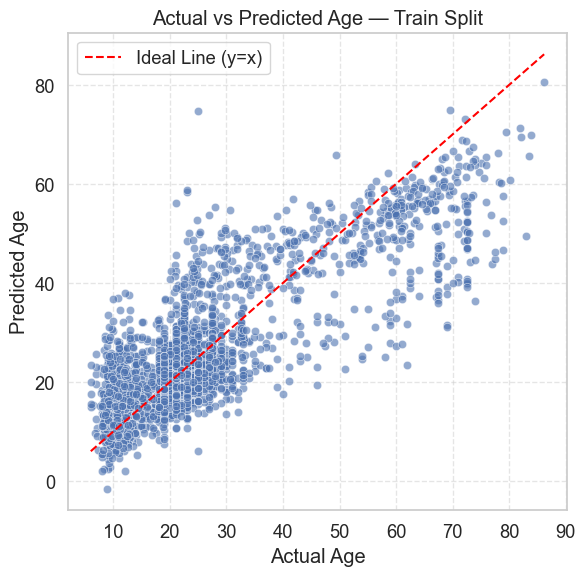

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(df, split_name):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=df["Actual_Age"], y=df["Predicted_Age"], alpha=0.6)
    plt.plot([df["Actual_Age"].min(), df["Actual_Age"].max()],
             [df["Actual_Age"].min(), df["Actual_Age"].max()],
             color='red', linestyle='--', label="Ideal Line (y=x)")
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")
    plt.title(f"Actual vs Predicted Age — {split_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_actual_vs_predicted(train_age_table, "Train Split")


 Saved external_test age comparison file to: outputs\age_error_table_external_test.csv


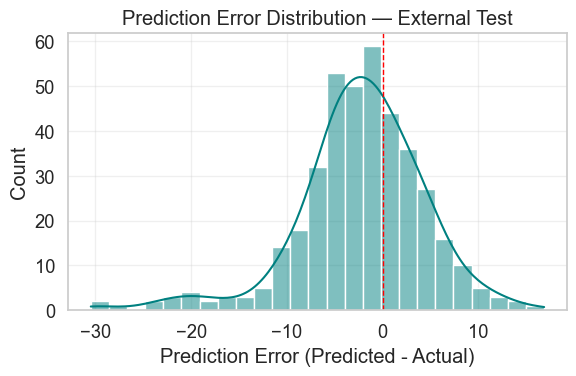

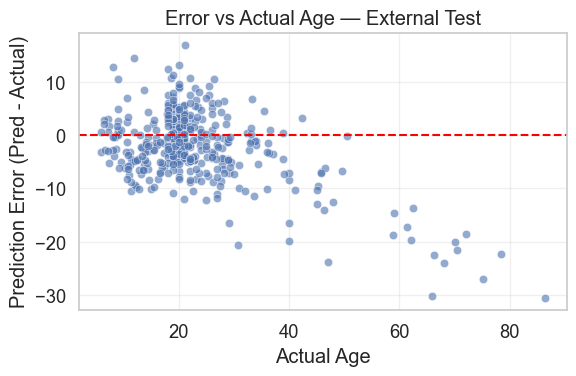

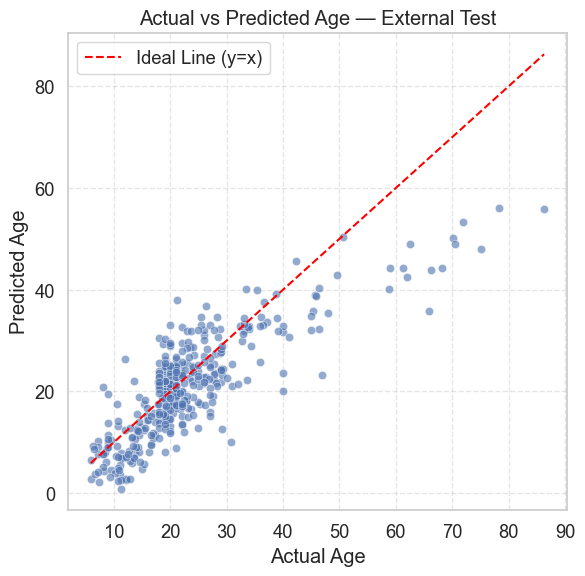


 External Test Set Performance:
 MAE (Mean Absolute Error): 5.123
 R² Score: 0.654
 Mean Error (Pred - Actual): -2.245

 External test evaluation completed!
Results saved to: outputs/external_test_predictions.csv


In [20]:
# === STEP 15 — Evaluate Model on Unseen External Test Data ===

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Generate predictions for the external test split
external_age_table = generate_age_error_table(
    split_name="external_test",
    df=external_df,
    model=best_model,
    feature_cols=feature_cols,
    scaler=scaler,
    pca=pca,
    out_dir="outputs"
)

# Add to results dictionary for unified evaluation
results["external_test"] = external_age_table

#  Visualize error distribution and scatter for external test
plot_error_distribution(external_age_table, "External Test")
plot_error_vs_age(external_age_table, "External Test")
plot_actual_vs_predicted(external_age_table, "External Test")

# Compute quantitative performance metrics
y_true = external_age_table["Actual_Age"].values
y_pred = external_age_table["Predicted_Age"].values

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mean_error = np.mean(y_pred - y_true)

print("\n External Test Set Performance:")
print(f" MAE (Mean Absolute Error): {mae:.3f}")
print(f" R² Score: {r2:.3f}")
print(f" Mean Error (Pred - Actual): {mean_error:.3f}")

#  Save final results
os.makedirs("outputs", exist_ok=True)
external_age_table.to_csv("outputs/external_test_predictions.csv", index=False)

print("\n External test evaluation completed!")
print("Results saved to: outputs/external_test_predictions.csv")
